# Infer ***cytoplasm*** from a composite image of organelles - 1️⃣ 

> WARNING: (🚨🚨🚨🚨 Steps 2-9 depend on establishing a good solution here.)

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #2: ***cytoplasm***  in order to understand the organelle interactome 

Infer a segmentation of the ***cytoplasm*** in order to measure its shape, position, size, and interaction with other organelles/cellular components.  

## OVERVIEW:

We will infer the cytoplasm using an weighted aggregate of multiple organelle channels.

Dependencies:
***nuclei*** and ***cell mask*** inference rely on the ***cytoplasm*** inference.  Therefore all of the sub-cellular objects rely on the cytoplasm segmentation.




### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from aicssegmentation.core.pre_processing_utils import  intensity_normalization, image_smoothing_gaussian_slice_by_slice 
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label
import skimage


# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.core.file_io import (read_czi_image,
                                                                    list_image_files)
from infer_subc_2d.core.img import *
from infer_subc_2d import organelles
       

%load_ext autoreload
%autoreload 2


## SETUP
CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

#### Get and load an image - specifically for __multichannel "raw"__ images

In [ ]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
# CUSTOMIZE HERE --->
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

# linearly unmixed ".czi" files are here
# CUSTOMIZE HERE --->
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files in "raw"
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [ ]:
# isolate image as an ndarray and metadata as a dictionary
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


### Get and load Image for processing - specifically for __pre-processed__ images

> #### Preprocessing:
> In this instance, we are using [Huygens Essential Software](https://svi.nl/Homepage) to deconvolve 3D fluorescence confocal images. The output is an OME TIFF file which contains the z-slices and channels in axis 0 (channel 0, zslice 1-40, channel 1, etc. etc.).

An OME TIFF reads in as a dask array (similar to a numpy array, but has a slightly different format)

In [2]:
# this will be the example for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Documents\Python Scripts\Infer-subc-2D"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "neuron_raw_OME"
im_type = ".tiff"

# get the list of all files in "raw"
img_file_list = list_image_files(data_path,im_type)
# test_img_name = img_file_list[test_img_n]
# test_img_name

img_file_list

['C:\\Users\\Shannon\\Documents\\Python Scripts\\Infer-subc-2D\\neuron_raw_OME\\20221027_C2-107_well_1_cell_1_untreated_Linear_unmixing_decon.ome.tiff']

In [3]:
#select one image
test_img = img_file_list[0]

# isolate image as an ndarray and metadata as a dictionary
img_data, meta_dict = read_czi_image(test_img)

# # get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
huygens_meta = meta_dict['metadata']['raw_image_metadata']

c:\Users\Shannon\Anaconda3\envs\infer-subc-2D\lib\site-packages\ome_types\_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## infer ***cytoplasm*** from data without nuclei marker


### INPUT

Get the "raw" signals we need to analyze as well as any other dependencies in "inferred" objects.  

In [4]:
###################
# INPUT
###################
weights = [0,4,1,1,2,2]

cyto_struct_img_raw = make_aggregate(img_data, 
                                         weights[0], 
                                         weights[1], 
                                         weights[2], 
                                         weights[3], 
                                         weights[4], 
                                         weights[5],
                                         scale_min_max=False) #channel order: LD, ER, golgi, lyso, mito, perox

weighted_aggregate: shape in- (6, 49, 1688, 1688) , shape_out- (49, 1688, 1688)


### PRE-PROCESSING

In [ ]:
###################
# PRE_PROCESSING
###################           
# cyto_med_filter_size = 0
# cyto_gaussian_smoothing_sigma = 0
# cyto_struct_img_smooth = scale_and_smooth(cyto_struct_img_raw, median_sz=cyto_med_filter_size, gauss_sig=cyto_gaussian_smoothing_sigma)

# cyto_log, d = log_transform(cyto_struct_img_smooth)
# cyto_composite = min_max_intensity_normalization(cyto_log)

In [ ]:
### wrapper function for cytoplasm preprocessing
def log_rescale_wrapper(img_in: np.ndarray) -> np.ndarray:
    """
    function to min-max normalize a gray-scale image, log transform it, then min-max normalize the log-scaled image
    """
    img = min_max_intensity_normalization(img_in)
    img, d = log_transform(img)
    img = min_max_intensity_normalization(img)

    log_norm_img = img

    return log_norm_img

In [5]:
from infer_subc_2d.core.img import log_rescale_wrapper

cyto_struct_img = log_rescale_wrapper(cyto_struct_img_raw)

### CORE PROCESSING

In [ ]:
###################
# CORE_PROCESSING
###################
cyto_low_level_min_size = 50
cyto_thresh_method = 'ave'
cyto_local_adjust = 0.05
cyto_bw = masked_object_thresh(cyto_struct_img, th_method=cyto_thresh_method, cutoff_size=cyto_low_level_min_size, th_adjust=cyto_local_adjust)

### POST PROCESSING

In [ ]:
###################
# POST_PROCESSING
###################
cyto_holefill_min = 0
cyto_holefill_max = 30
cyto_small_object_width = 10
cyto_method = '3D'
cyto_connectivity = 1
cyto_cleaned_img = fill_and_filter_linear_size(cyto_bw, hole_min=cyto_holefill_min, hole_max=cyto_holefill_max, min_size=cyto_small_object_width, method=cyto_method, connectivity=cyto_connectivity)

In [ ]:
### Wrapper function for cytoplasm core and post processing
def _infer_cytoplasm_fromaggr(img_in: np.ndarray,
                             th_method: str,
                             th_cutoff_sz: str,
                             th_adjust: str,
                             smallhole_min_sz: int,
                             smallhole_max_sz: int,
                             smallobj_max_sz: int,
                             slices_or_3D: str,
                             filter_connectivity: int) -> np.ndarray:
    """ 
    Procedure to mask the cytoplasmic area of a cell (based on 'MO' tresholding from 'aicssegmentation'). Includes hole and size filtering.

    Parameters
    ----------
    img_in: np.dnarray
        Grey scale fluorescence image of cytoplasmic area. Image should already be preprocessed (smoothing, rescaling, etc.)
    th_method: str
        Threshold method for masked_object_threshold() function in infer_subc_2D.core.img.
        Options: "triangle", "median", and "ave_tri_med"
    th_cutoff_sz: str 
        Maximum object size for masked_object_threshold() function in infer_subc_2D.core.img.
    th_adjust: str
        Local threshold adjustment value for masked_object_threshold() function in infer_subc_2D.core.img.
    smallhole_min_sz: int
        Minimum size of hole to fill in cytoplasm mask.
    smallhole_max_sz: int
        Maximum size of hole to fill in cytoplasm mask.
    smallobj_max_sz: int
        Maximum small object size to remove from cytoplasm mask.
    slices_or_3D: str
        Should the filtering be performed slice-by-slice or in 3D?
        Options: 'slice-by-slice', or '3D'
    filter_connectivity: int
        Connectivity of objects in cytoplasm mask for filtering function

    Output
    ------
    cytoplasm_mask: np.ndarray
        binary image of cyplasmic area (cell area without nucleus)
    """
    ###################
    # CORE_PROCESSING
    ###################
    cyto_bw = masked_object_thresh(cyto_struct_img, th_method=th_method, cutoff_size=th_cutoff_sz, th_adjust=th_adjust)
    
    ###################
    # POST_PROCESSING
    ###################
    cyto_cleaned_img = fill_and_filter_linear_size(cyto_bw, hole_min=smallhole_min_sz, hole_max=smallhole_max_sz, min_size=smallobj_max_sz, method=slices_or_3D, connectivity=filter_connectivity)
    cytoplasm_mask = cyto_cleaned_img

    return cytoplasm_mask 

In [6]:
from infer_subc_2d.organelles.cytoplasm import infer_cytoplasm_fromaggr

cyto_cleaned_img = infer_cytoplasm_fromaggr(cyto_struct_img,
                             th_method= 'ave_tri_med',
                             th_cutoff_sz= 50,
                             th_adjust= 0.05,
                             smallhole_min_sz= 0,
                             smallhole_max_sz= 30,
                             smallobj_max_sz= 10,
                             slices_or_3D= '3D',
                             filter_connectivity= 3)

### RENAMING

In [7]:
###################
# RENAMING
###################
cytoplasm_mask = cyto_cleaned_img.astype(dtype=int)

## Visualize 1

In [8]:
viewer = napari.Viewer()

In [9]:
viewer.add_image(img_data, scale=scale)
viewer.add_image(cyto_struct_img, scale=scale)
viewer.add_image(cytoplasm_mask, scale=scale, opacity=0.25, colormap='bop orange')

<Image layer 'cytoplasm_mask' at 0x22cbca40850>

In [10]:
viewer.close()

## DEFINE `_infer_cytoplasm_from_composite` function

Based on the _prototyping_ above define the function to infer nuclei.  


In [11]:
##########################
#  _infer_cytoplasm_from_composite
##########################
def _infer_cytoplasm_fromaggr_wrapper(in_img: np.ndarray,
                                    weights: list,
                                    th_method: str,
                                    th_cutoff_sz: str,
                                    th_adjust: str,
                                    smallhole_min_sz: int,
                                    smallhole_max_sz: int,
                                    smallobj_max_sz: int,
                                    slices_or_3D: str,
                                    filter_connectivity: int) -> np.ndarray:
    """
    Wrapper function for infer_cytoplasm_fromaggr(). 
    Includes preprocessing steps: create weighted aggregate image, rescale, log, rescale

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    weights: list
        a list of weights for each channel in the image to create a merged image; 
        set to 0 if the channel should not be used
    img_in: np.dnarray
        Grey scale fluorescence image of cytoplasmic area. Image should already be preprocessed (smoothing, rescaling, etc.)
    th_method: str
        Threshold method for masked_object_threshold() function in infer_subc_2D.core.img.
        Options: "triangle", "median", and "ave_tri_med"
    th_cutoff_sz: str 
        Maximum object size for masked_object_threshold() function in infer_subc_2D.core.img.
    th_adjust: str
        Local threshold adjustment value for masked_object_threshold() function in infer_subc_2D.core.img.
    smallhole_min_sz: int
        Minimum size of hole to fill in cytoplasm mask.
    smallhole_max_sz: int
        Maximum size of hole to fill in cytoplasm mask.
    smallobj_max_sz: int
        Maximum small object size to remove from cytoplasm mask.
    slices_or_3D: str
        Should the filtering be performed slice-by-slice or in 3D?
        Options: 'slice-by-slice', or '3D'
    filter_connectivity: int
        Connectivity of objects in cytoplasm mask for filtering function

    Output
    ------
    cytoplasm_mask: np.ndarray
        binary image of cytoplasmic area  (cell area without nucleus)
    
    """

    ###################
    # INPUT
    ###################
    composite = make_aggregate(in_img, weights[0], weights[1], weights[2], weights[3], weights[4], weights[5], scale_min_max=False)

    ###################
    # PRE_PROCESSING
    ###################           
    struct_img = log_rescale_wrapper(composite)

    ###################
    # CORE_PROCESSING
    ###################
    cleaned_img = infer_cytoplasm_fromaggr(struct_img,
                             th_method=th_method,
                             th_cutoff_sz=th_cutoff_sz,
                             th_adjust=th_adjust,
                             smallhole_min_sz= smallhole_min_sz,
                             smallhole_max_sz=smallhole_max_sz,
                             smallobj_max_sz=smallobj_max_sz,
                             slices_or_3D=slices_or_3D,
                             filter_connectivity=filter_connectivity)
    
    ###################
    # RENAMING
    ###################
    cytoplasm_mask = cleaned_img.astype(dtype=int)

    return cytoplasm_mask


## DEFINE `_fixed_infer_cytoplasm_from_composite` function


In [12]:
##########################
#  fixed_infer_cytoplasm_from_composite
##########################
def _fixed_infer_cytoplasm_fromaggr_wrapper(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: np.ndarray
        mask
 
    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    weights = [0,4,1,1,2,2]
    th_method= 'ave'
    th_cutoff_sz= 50
    th_adjust= 0.05
    smallhole_min_sz= 0
    smallhole_max_sz= 30
    smallobj_max_sz= 10
    slices_or_3D= '3D'
    filter_connectivity= 1


    return _infer_cytoplasm_fromaggr_wrapper(in_img,
                                            weights,
                                            th_method,
                                            th_cutoff_sz,
                                            th_adjust,
                                            smallhole_min_sz,
                                            smallhole_max_sz,
                                            smallobj_max_sz,
                                            slices_or_3D,
                                            filter_connectivity)

---------------------
## TEST `_infer_cytoplasm_from_composite`  function defined above


In [13]:
_cytoplasm_mask =  _fixed_infer_cytoplasm_fromaggr_wrapper(img_data) 

weighted_aggregate: shape in- (6, 49, 1688, 1688) , shape_out- (49, 1688, 1688)


In [14]:
viewer = napari.Viewer()
viewer.add_image(img_data, scale=scale)
viewer.add_image(_cytoplasm_mask, scale=scale)

<Image layer '_cytoplasm_mask' at 0x22cbe4dfa30>

In [24]:
viewer.close()

---------------------
# TEST `infer_cytoplasm_from_composite` exported functions

> the prototype `_infer_nuclei` was copied to the [`.organelles.cytoplasm`](../infer_subc_2d/organelles/cytoplasm.py) sub-module 
##
`infer_cytoplasm_from_composite` procedure

Use the `infer_cytoplasm_from_composite` function to infer the Nucleus and export it as an _ome.tif_ for easy reference.

In [15]:
from infer_subc_2d.organelles.cytoplasm import fixed_infer_cytoplasm_fromaggr_wrapper
cytoplasm_mask_2 =  fixed_infer_cytoplasm_fromaggr_wrapper(img_data) 


weighted_aggregate: shape in- (6, 49, 1688, 1688) , shape_out- (49, 1688, 1688)


## Visualize  2


In [16]:
viewer = napari.Viewer()

In [20]:
viewer.add_image(cyto_struct_img, scale=scale)
viewer.add_image(cytoplasm_mask_2, scale=scale, opacity=0.25, colormap='bop orange')

<Image layer 'cytoplasm_mask_2' at 0x22cd28bb040>

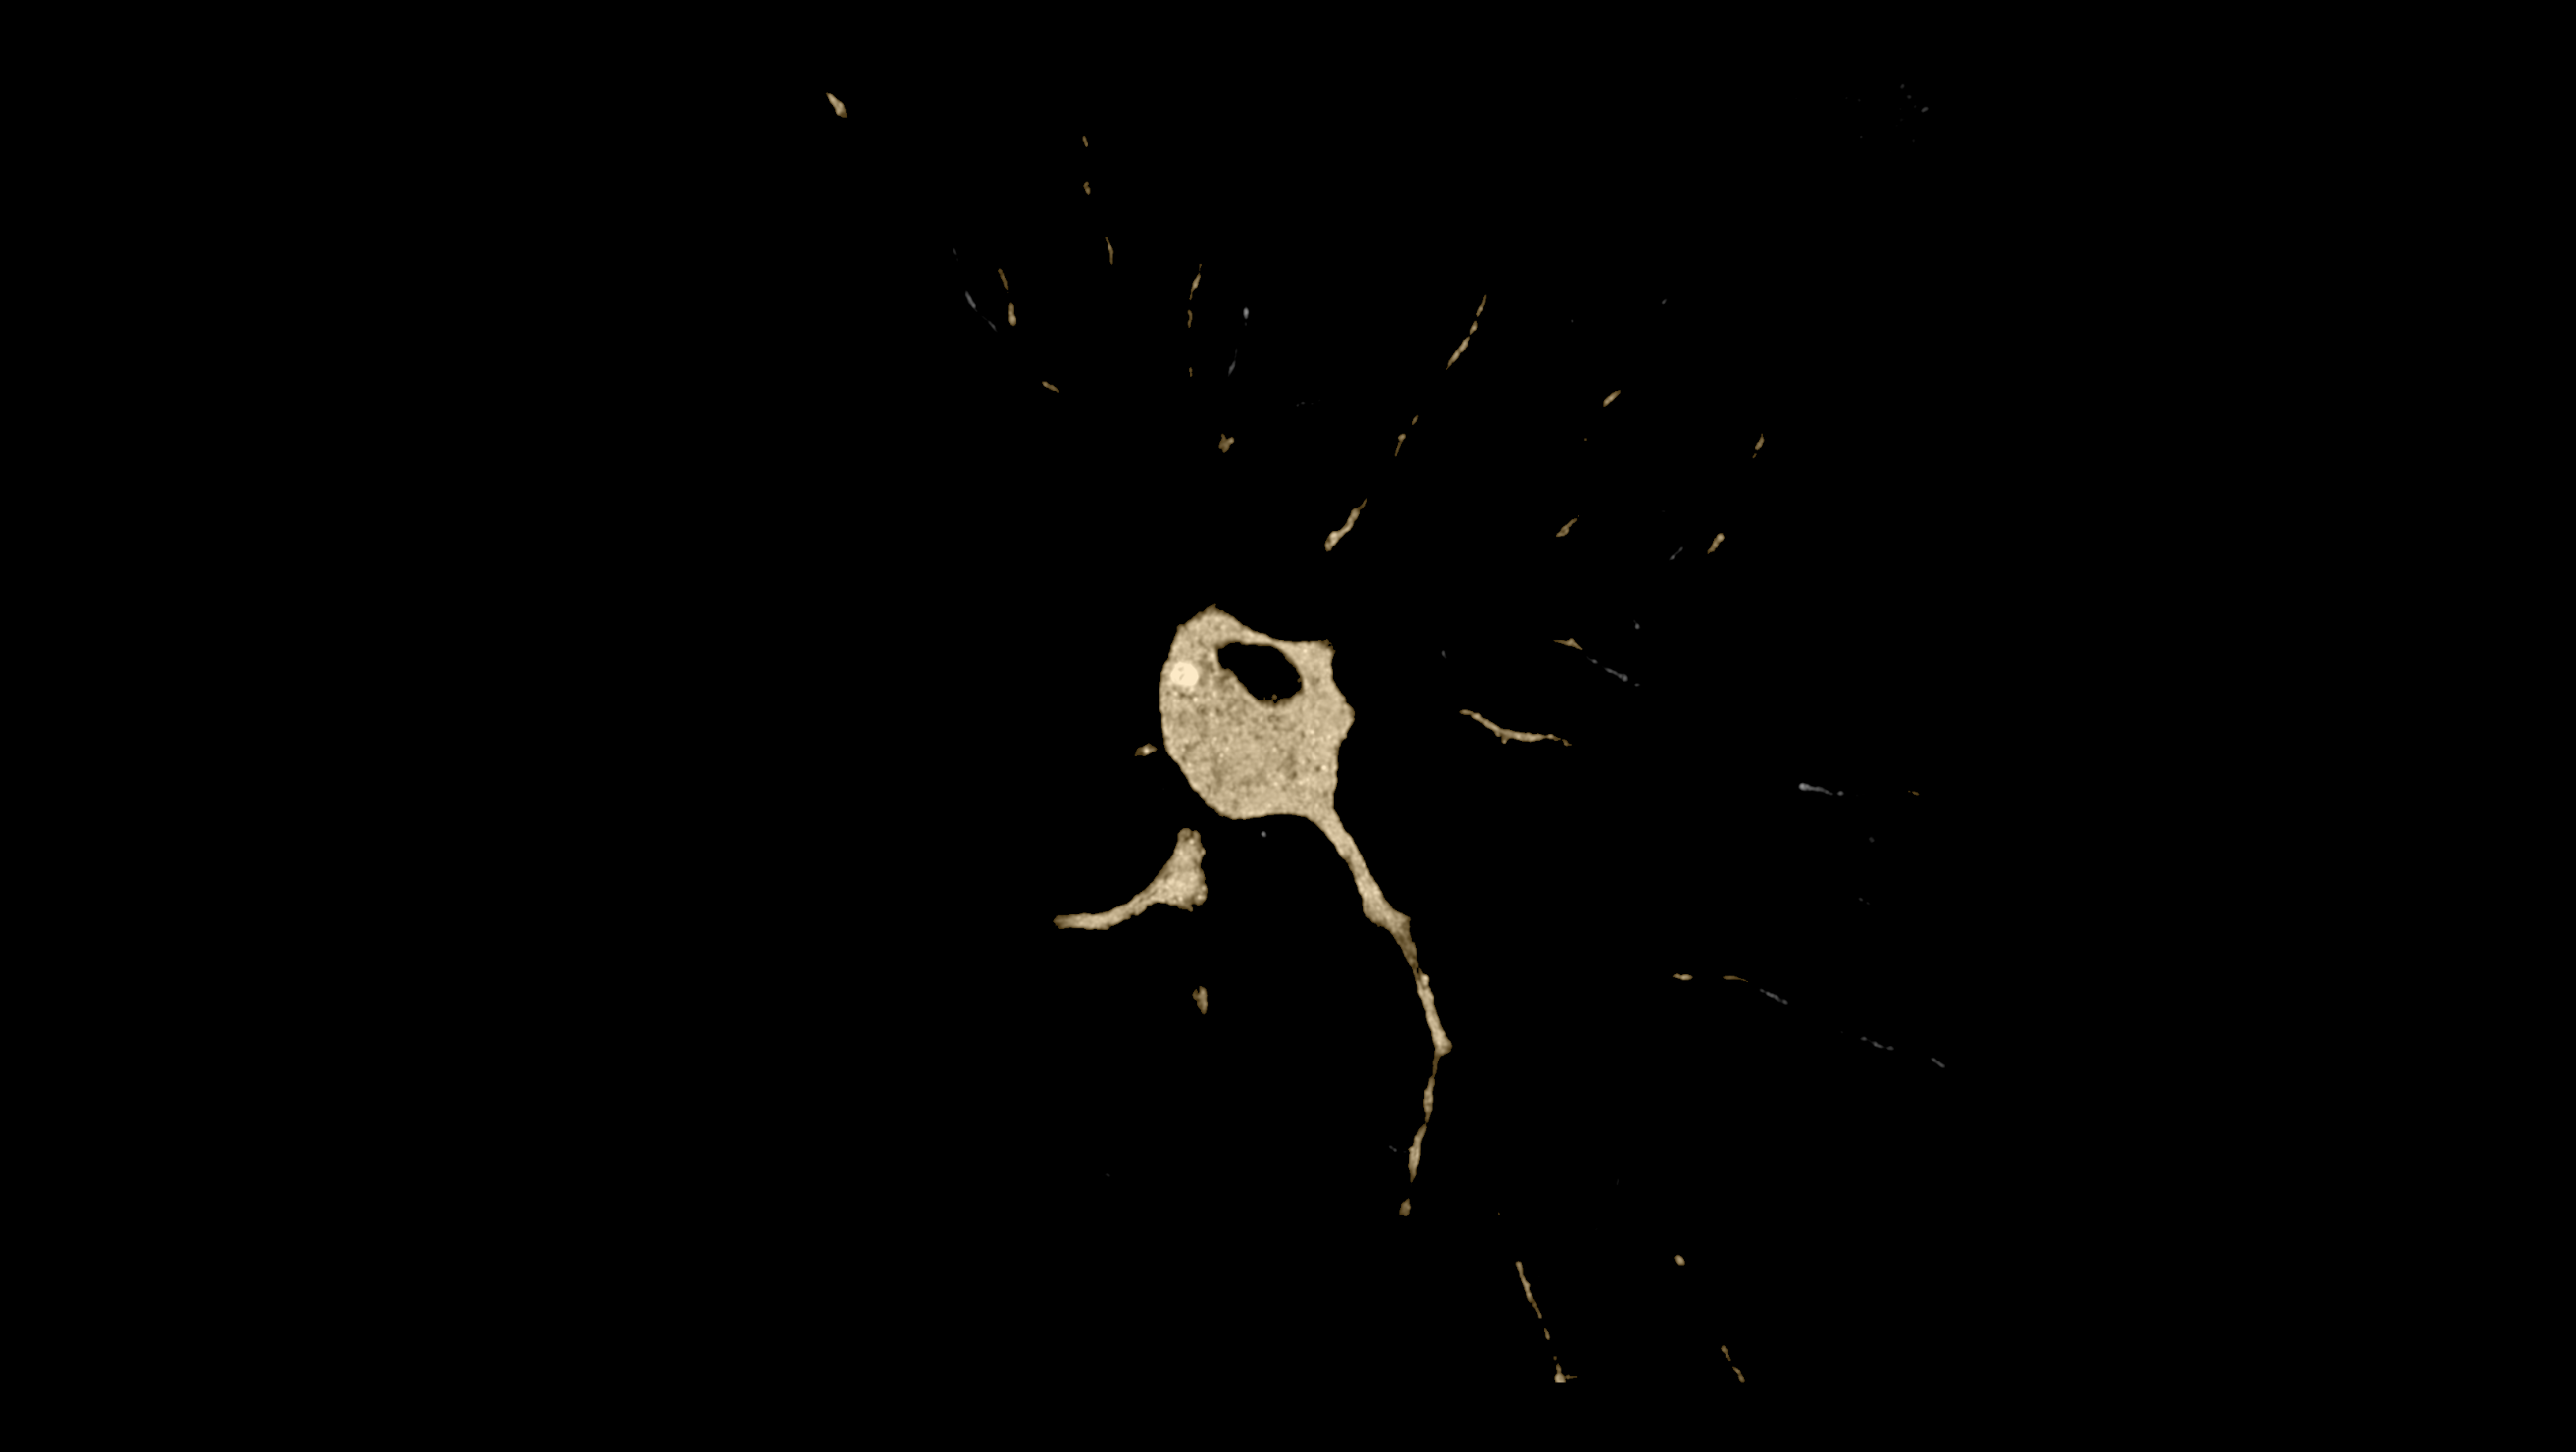

In [22]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [23]:
viewer.close()

-------------
## SUMMARY

The above details how the cytoplasm object is inferred from a composite image of fluorescnet organelles channels.

### NEXT: INFER NUCLEUS AND CELL MASKS

proceed to [02_infer_nucleus_cellmask_from_cytoplasm.ipynb](./02_infer_nucleus_cellmask_from_cytoplasm.ipynb)
